# SBERT Stacking Classifier

# Student Name : Kanishkar Thirunavukkarasu

# Student ID : D23124630

# Importing Libraries

In [3]:
!pip install xgboost
!pip install catboost
!pip install lightgbm
!pip install -U sentence-transformers
!pip install hyperopt
!pip install optuna

import optuna
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

C:\Users\kanis\AppData\Local\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Loading

In [4]:
df= pd.read_csv("D:\\Learnings\\Masters_TUD\\Dissertation\\SBERT_Phishing_Detection\\Datasets\\S_BERT_Phishing_Dataset.csv")

In [5]:
type_counts = df['type'].value_counts()
type_counts

type
0    214628
1    201766
Name: count, dtype: int64

In [6]:
df.tail()

,url,type
416389,https://www.liquidsaltmag.com/2011/02/shayne-m...,0
416390,nndb.com/people/339/000022273/,0
416391,https://www.billboard.com/artist/france-joli/b...,0
416392,https://www.elections.nytimes.com/2010/governo...,0
416393,https://www.oregonfocus.com/,0


# Dataset Preprocessing

## Handling Missing Data

In [11]:
df=df.dropna()

In [18]:
df.shape

(416394, 2)

## Handling duplicate Data

In [17]:
df=df.drop_duplicates(subset='url')

In [ ]:
df.shape

## Removing any quotes in front or back of URLs

In [24]:
df['url'] = df['url'].str.strip("'")

In [25]:
df.shape

(416394, 20)

## Data Type Conversion

In [13]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols

['url']

In [14]:
l_encoder = LabelEncoder()

encoded_data = l_encoder.fit_transform(df['type'])

df['type'] = encoded_data

In [15]:
df.tail()

,url,type
416389,https://www.liquidsaltmag.com/2011/02/shayne-m...,0
416390,nndb.com/people/339/000022273/,0
416391,https://www.billboard.com/artist/france-joli/b...,0
416392,https://www.elections.nytimes.com/2010/governo...,0
416393,https://www.oregonfocus.com/,0


## URL Lexical Feature Extraction

In [16]:
import urllib.parse
from urllib.parse import unquote
import re
import math


def extract_URL_features(url):

  try:

    features = {}

    url=unquote(url) # convert encoding to text in URL

    parsed_url = urllib.parse.urlparse(url)

    if(("//") not in url):

      url=url.strip("//")

      url_path="".join([part for part in url.split("/")[1:]])

      features['url_length']=len(url)

      features['domain_length']=len(url.split("/")[0])

      features['path_length'] = (sum(len(part) for part in url.split("/")[1:]))

      domain_parts=url.split("/")[0].split('.')

      features['num_subdomains'] = len(domain_parts) - 2 if  (len(domain_parts) - 2 ) > 0 else 0

      features['subdomain_length'] = (sum(len(part) for part in domain_parts[:-2])) if sum(len(part) for part in domain_parts[:-2])>0 else 0

      features['path_depth'] = len(url.split("/"))

      features['has_file_extension'] = 1 if re.search(r'\.\w+$', url_path) else 0

      features['equal_count'] = url.count('=')
      features['redirects'] = url.count('//')
      features['query_param_count'] = url.count('?')
      features['dot_char_count'] = url.count('.')
      features['hyphen_char_count'] = url.count('-')
      features['tld_domain_length']= len(domain_parts[-1]) if (len(domain_parts[-1]) > 0)  else 0
      features['space_char_count'] = url.count(' ')+url.count('+')
      features['www_count'] = url.count('www')
      features['http_count'] = url.count('http')

      # Digit to letter ratio
      digit_count = sum(1 for char in url_path if char.isdigit())
      letter_count = sum(1 for char in url_path if char.isalpha())
      features['digit_letter_ratio'] = digit_count / letter_count if letter_count > 0 else 0


      suspicious_keywords = ["login", "update", "verify", "secure", "account","password","reset", "banking", "confirm", "signin"]
      features['suspicious_path_keywords'] = sum(word in url_path.lower() for word in suspicious_keywords)


    else:

      domain_parts = parsed_url.netloc.split('.')
      
      features['url_length']=len(url)
      # print("url : ",url)

      features['domain_length']=len(parsed_url.netloc)
      # print("domain : ",parsed_url.netloc)

      features['path_length'] = len(parsed_url.path)
      # print("path : ",parsed_url.path)

      features['num_subdomains'] = len(domain_parts) - 2 if  (len(domain_parts) - 2 ) > 0 else 0
      # print("domain :",domain_parts)

      features['subdomain_length'] = (sum(len(part) for part in domain_parts[:-2])) if sum(len(part) for part in domain_parts[:-2])>0 else 0
      features['path_depth'] = parsed_url.path.count('/')
      features['has_file_extension'] = 1 if re.search(r'\.\w+$', parsed_url.path) else 0
      features['equal_count'] = url.count('=')
      features['redirects'] = url.count('//')
      features['query_param_count'] = url.count('?')
      features['dot_char_count'] = url.count('.')
      features['hyphen_char_count'] = url.count('-')
      features['tld_domain_length']= len(domain_parts[-1]) if (len(domain_parts[-1]) > 0)  else 0
      features['space_char_count'] = url.count(' ')+url.count('+')
      features['www_count'] = url.count('www')
      features['http_count'] = url.count('http')

      digit_count = sum(1 for char in parsed_url.path if char.isdigit())
      letter_count = sum(1 for char in parsed_url.path if char.isalpha())
      features['digit_letter_ratio'] = digit_count / letter_count if letter_count > 0 else 0

      suspicious_keywords = ["login", "update", "verify", "secure", "account","password", "reset", "banking", "confirm", "signin"]
      features['suspicious_path_keywords'] = sum(word in parsed_url.path.lower() for word in suspicious_keywords)

  except Exception as e:
    print("Exception in URL :",url)
    return None  # Return None or a default value for failed cases

  return features


In [19]:
fs=df['url'].map(extract_URL_features)

In [20]:
fs=fs.to_list()

In [21]:
url_features_frame = pd.json_normalize(fs)

In [22]:
df = pd.concat([df, url_features_frame], axis=1)
df.shape

(416394, 20)

In [23]:
df.tail()

,url,type,url_length,domain_length,path_length,num_subdomains,subdomain_length,path_depth,has_file_extension,equal_count,redirects,query_param_count,dot_char_count,hyphen_char_count,tld_domain_length,space_char_count,www_count,http_count,digit_letter_ratio,suspicious_path_keywords
416389,https://www.liquidsaltmag.com/2011/02/shayne-m...,0,54,21,25,1,3,4,0,0,1,0,2,1,3,0,1,1,0.428571,0
416390,nndb.com/people/339/000022273/,0,29,8,18,0,0,4,0,0,0,0,1,0,3,0,0,0,2.000000,0
416391,https://www.billboard.com/artist/france-joli/b...,0,54,17,29,1,3,4,0,0,1,0,2,1,3,0,1,1,0.263158,0
416392,https://www.elections.nytimes.com/2010/governo...,0,56,25,23,2,12,3,0,0,1,0,3,0,3,0,1,1,0.250000,0
416393,https://www.oregonfocus.com/,0,28,19,1,1,3,1,0,0,1,0,2,0,3,0,1,1,0.000000,0


# Data Visualization

In [30]:
counts = df['type'].value_counts()
counts.index = ['Legitimate', 'Phishing']

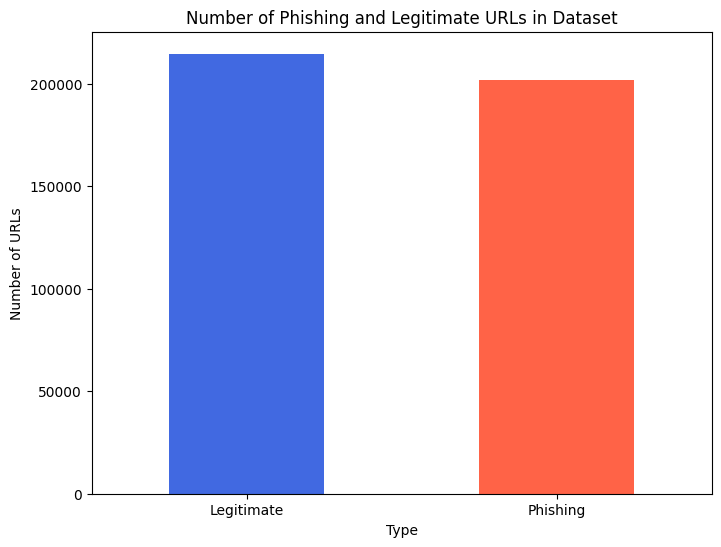

In [31]:
plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color=['royalblue', 'tomato'],rot=0)

# Labeling
plt.xlabel('Type')
plt.ylabel('Number of URLs')
plt.title('Number of Phishing and Legitimate URLs in Dataset')

# Show the plot
plt.show()

In [27]:
import pandas as pd

bins = [0, 50, 70, 100, 200, 300, float('inf')]
labels = ['0-50', '50-70', '70-100','100-200', '200-300', '300+']


df['url_length_range'] = pd.cut(df['url_length'], bins=bins, labels=labels)

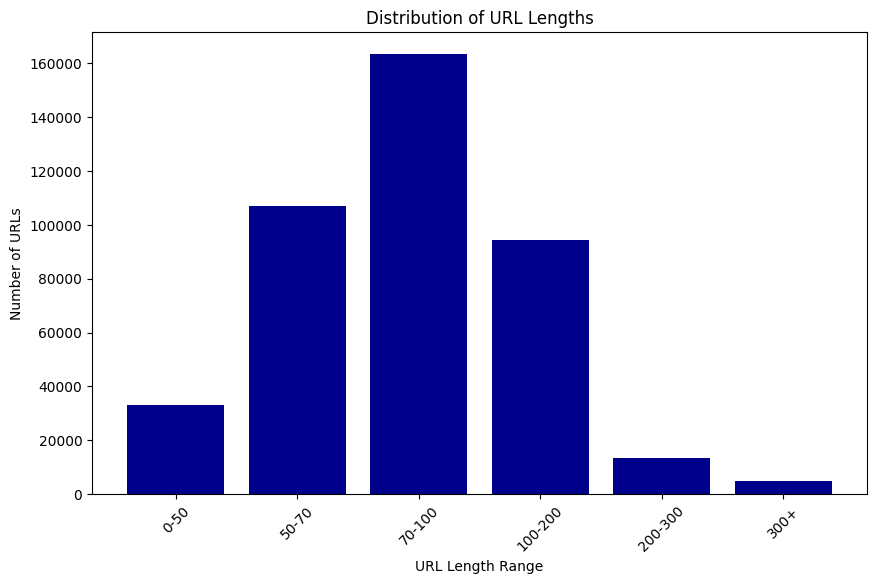

In [28]:
import matplotlib.pyplot as plt

# Step 4: Count the number of URLs in each range
url_length_distribution = df['url_length_range'].value_counts().sort_index()

# Step 5: Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(url_length_distribution.index, url_length_distribution.values, color='darkblue')
plt.title('Distribution of URL Lengths')
plt.xlabel('URL Length Range')
plt.ylabel('Number of URLs')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
import matplotlib.pyplot as plt

df_visual = df.drop(columns=['url', 'type','embeddings'])

plt.figure(figsize=(14, 12))
sns.heatmap(df_visual.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

In [29]:
# checking for information and null values in dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416394 entries, 0 to 416393
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   url                       416394 non-null  object  
 1   type                      416394 non-null  int64   
 2   url_length                416394 non-null  int64   
 3   domain_length             416394 non-null  int64   
 4   path_length               416394 non-null  int64   
 5   num_subdomains            416394 non-null  int64   
 6   subdomain_length          416394 non-null  int64   
 7   path_depth                416394 non-null  int64   
 8   has_file_extension        416394 non-null  int64   
 9   equal_count               416394 non-null  int64   
 10  redirects                 416394 non-null  int64   
 11  query_param_count         416394 non-null  int64   
 12  dot_char_count            416394 non-null  int64   
 13  hyphen_char_count         416

# S-BERT URL Embeddings

In [23]:
s_bert_model = SentenceTransformer("all-distilroberta-v1")
features=[]

for i in range(len(df["url"])):
    features.append(s_bert_model.encode(df.iloc[i]["url"]))


In [ ]:
np.save('D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\Final\\SBERT_400k_embeddings.npy',features)

## Load Embedding

In [33]:
all_embeddings = np.load('D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\Final\\SBERT_400k_embeddings.npy', allow_pickle=True)

In [46]:
all_embeddings.shape

(416394,)

In [45]:
all_embeddings[0].shape

(768,)

In [47]:
df['embeddings'] = [embedding for embedding in all_embeddings]

In [48]:
df.shape

(416394, 22)

In [50]:
#Removing url_length_range as it is not needed in classification
df= df.drop(columns=['url_length_range'])

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416394 entries, 0 to 416393
Data columns (total 21 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   url                       416394 non-null  object 
 1   type                      416394 non-null  int64  
 2   url_length                416394 non-null  int64  
 3   domain_length             416394 non-null  int64  
 4   path_length               416394 non-null  int64  
 5   num_subdomains            416394 non-null  int64  
 6   subdomain_length          416394 non-null  int64  
 7   path_depth                416394 non-null  int64  
 8   has_file_extension        416394 non-null  int64  
 9   equal_count               416394 non-null  int64  
 10  redirects                 416394 non-null  int64  
 11  query_param_count         416394 non-null  int64  
 12  dot_char_count            416394 non-null  int64  
 13  hyphen_char_count         416394 non-null  i

# Dataset splitting

In [53]:
from sklearn.preprocessing import StandardScaler

#Selecting numeric features excluding object types
features = df.drop(columns=['type', 'embeddings','url'])

#Normalizing numeric features if necessary
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

#Converting embeddings to a 2D array
embeddings_array = np.stack(df['embeddings'].values)

#Concatenating features and embeddings
X = np.hstack((features_scaled, embeddings_array))
y = df['type'].values

## Train Test Split

In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y)

# Base Learner Filtering for Stacking Classifier 

## Logistic Regression

In [62]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

C:\Users\kanis\AppData\Local\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [63]:
lr_pred = lr.predict(X_test)
print("LR Classifier Accuracy:",metrics.accuracy_score(y_test, lr_pred))
print("LR Classifier Recall:",metrics.recall_score(y_test, lr_pred))
print("LR Classifier Precision:",metrics.precision_score(y_test, lr_pred))

LR Classifier Accuracy: 0.95736019884965
LR Classifier Recall: 0.9520729561618715
LR Classifier Precision: 0.9596113497851934


## KNN

In [64]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print("KNN Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

KNN Accuracy: 0.9834051801774757
KNN Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98     42926
           1       0.98      0.98      0.98     40353

    accuracy                           0.98     83279
   macro avg       0.98      0.98      0.98     83279
weighted avg       0.98      0.98      0.98     83279

KNN Confusion Matrix:
 [[42297   629]
 [  753 39600]]


## Naive Bayes

In [65]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

In [66]:
y_pred_nb = gnb.predict(X_test)

In [67]:
print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred_nb)*100)

Gaussian Naive Bayes model accuracy(in %): 84.66480145054575


## Gradient Boosting Classifier (GBDT)

In [150]:
from sklearn.ensemble import  GradientBoostingClassifier

gbdt_model = GradientBoostingClassifier(n_estimators = 15, max_features = None, min_samples_split = 2)
gbdt_model.fit(X_train, y_train)

y_pred_gbdt=gbdt_model.predict(X_test)

In [152]:
print("GBDT Accuracy:", accuracy_score(y_test, y_pred_gbdt))

GBDT Accuracy: 0.924394726131304


## Random Forest

In [125]:
from sklearn.ensemble import RandomForestClassifier

RF_model= RandomForestClassifier()
RF_model.fit(X_train, y_train)

RandomForestClassifier()

In [126]:
y_pred_rf=RF_model.predict(X_test)

In [127]:
print("RF Accuracy:", accuracy_score(y_test, y_pred_rf))

RF Accuracy: 0.969091847884821


## XG Boost 

In [109]:
clf_xgb = XGBClassifier()

In [110]:
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [111]:
XGB_pred = clf_xgb.predict(X_test)
print("XG Boost Classifier Accuracy:",metrics.accuracy_score(y_test, XGB_pred))
print("XG Boost Classifier Recall:",metrics.recall_score(y_test, XGB_pred))
print("XG Boost Classifier Precision:",metrics.precision_score(y_test, XGB_pred))

XG Boost Classifier Accuracy: 0.9839695481453908
XG Boost Classifier Recall: 0.9812157708224916
XG Boost Classifier Precision: 0.985636761923728


## LightGBM 

In [71]:
clf_lgb=LGBMClassifier()

In [72]:
clf_lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 161413, number of negative: 171702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.840120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197263
[LightGBM] [Info] Number of data points in the train set: 333115, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484556 -> initscore=-0.061794
[LightGBM] [Info] Start training from score -0.061794


LGBMClassifier()

In [73]:
clf_lgb_predict = clf_lgb.predict(X_test)
print("LightGBM Classifier Accuracy:",accuracy_score(y_test, clf_lgb_predict))
print("LightGBM Classifier Recall:",recall_score(y_test, clf_lgb_predict))
print("LightGBM Classifier Precision:",precision_score(y_test, clf_lgb_predict))

LightGBM Classifier Accuracy: 0.9727542357617166
LightGBM Classifier Recall: 0.964810546923401
LightGBM Classifier Precision: 0.9786586898597356


## CatBoost 

In [74]:
clf_cat = CatBoostClassifier(iterations=1000)

clf_cat.fit(X_train, y_train,verbose=True)

Learning rate set to 0.12305
0:	learn: 0.5517133	total: 414ms	remaining: 6m 53s
1:	learn: 0.4513645	total: 689ms	remaining: 5m 43s
2:	learn: 0.3820132	total: 1.01s	remaining: 5m 35s
3:	learn: 0.3334510	total: 1.31s	remaining: 5m 25s
4:	learn: 0.3001525	total: 1.63s	remaining: 5m 23s
5:	learn: 0.2747212	total: 1.96s	remaining: 5m 25s
6:	learn: 0.2555875	total: 2.31s	remaining: 5m 27s
7:	learn: 0.2406368	total: 2.61s	remaining: 5m 23s
8:	learn: 0.2296965	total: 2.93s	remaining: 5m 22s
9:	learn: 0.2192818	total: 3.24s	remaining: 5m 20s
10:	learn: 0.2112157	total: 3.53s	remaining: 5m 17s
11:	learn: 0.2014126	total: 3.82s	remaining: 5m 14s
12:	learn: 0.1954458	total: 4.13s	remaining: 5m 13s
13:	learn: 0.1901189	total: 4.46s	remaining: 5m 14s
14:	learn: 0.1854586	total: 4.73s	remaining: 5m 10s
15:	learn: 0.1819883	total: 5.02s	remaining: 5m 8s
16:	learn: 0.1773690	total: 5.29s	remaining: 5m 5s
17:	learn: 0.1740493	total: 5.6s	remaining: 5m 5s
18:	learn: 0.1692686	total: 5.9s	remaining: 5m 4s

In [75]:
clf_cat_predict = clf_cat.predict(X_test)
print("CatBoost Classifier Accuracy:",accuracy_score(y_test, clf_cat_predict))
print("CatBoost Classifier Recall:",recall_score(y_test, clf_cat_predict))
print("CatBoost Classifier Precision:",precision_score(y_test, clf_cat_predict))

CatBoost Classifier Accuracy: 0.9865752470610838
CatBoost Classifier Recall: 0.9832726191361237
CatBoost Classifier Precision: 0.9889584008374667


# Base Learners (XGBoost, LightGBM, CatBoost, Random Forest) Hyperparameter Tuning

## XG Boost Hyperparamter Classifier

In [112]:
# Function for XGboost hyperparameters
def objective(trial):
    
  learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
  max_depth = trial.suggest_int("max_depth", 3, 10)
  colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
  n_estimators = trial.suggest_int("n_estimators", 50, 300)
  subsample = trial.suggest_float("subsample", 0.5, 1.0)
  
  # For training XGBoost model
  XGBmodel = XGBClassifier(
        learning_rate=learning_rate,
        max_depth=max_depth,
        colsample_bytree=colsample_bytree,
        n_estimators=n_estimators,
        subsample=subsample,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
  )
  XGBmodel.fit(X_train, y_train)
  
  # return the performance metric
  clf_XGB_pred = XGBmodel.predict(X_test)
  accuracy = metrics.accuracy_score(y_test, clf_XGB_pred)
  return accuracy

In [113]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Best trial:")
print(" Value: {}".format(study.best_trial.value))
print(" Params: {}".format(study.best_trial.params))

[I 2024-09-02 08:46:14,134] A new study created in memory with name: no-name-c7e94860-6b6b-416d-9fc8-eb8bfdaa1b20
C:\Users\kanis\AppData\Local\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:46:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-09-02 08:48:19,000] Trial 0 finished with value: 0.9650812329638925 and parameters: {'learning_rate': 0.11491360925133275, 'max_depth': 3, 'colsample_bytree': 0.7570729853018349, 'n_estimators': 188, 'subsample': 0.9146417637222171}. Best is trial 0 with value: 0.9650812329638925.
C:\Users\kanis\AppData\Local\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [08:48:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { 

Best trial:
 Value: 0.9882803587939336
 Params: {'learning_rate': 0.13754794938764422, 'max_depth': 9, 'colsample_bytree': 0.600977077478963, 'n_estimators': 243, 'subsample': 0.9024069904539187}


In [120]:
# Utlizing the model to see improvements in XGBoost classifier
clf_xgb = XGBClassifier(
    learning_rate=0.13754794938764422,
    max_depth=9,
    n_estimators=243,
    colsample_bytree=0.600977077478963,
    subsample=0.9024069904539187
)

In [121]:
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.600977077478963, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.13754794938764422,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=243, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [122]:
XGB_pred = clf_xgb.predict(X_test)
print("XG Boost Classifier Accuracy:",accuracy_score(y_test, XGB_pred))
print("XG Boost Classifier Recall:",recall_score(y_test, XGB_pred))
print("XG Boost Classifier Precision:",precision_score(y_test, XGB_pred))

XG Boost Classifier Accuracy: 0.988100241357365
XG Boost Classifier Recall: 0.9838921517607118
XG Boost Classifier Precision: 0.9914843671960843


In [79]:
# Make predictions
y_train_pred = clf_xgb.predict(X_train)
y_test_pred = clf_xgb.predict(X_test)

# Calculate accuracy
train_accuracy = metrics.accuracy_score(y_train, y_train_pred)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9939960674241628
Test Accuracy: 0.9828408122095607


In [80]:
fpr,tpr, thres=roc_curve(y_test, XGB_pred)

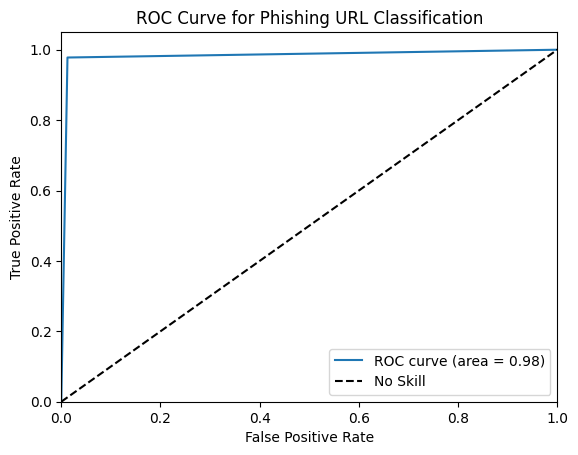

In [81]:
roc_auc = auc(fpr, tpr)
# Plot the ROC curve
plt.figure()  
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Phishing URL Classification')
plt.legend()
plt.show()

## LightGBM Hyperparmeter Grid Search

In [247]:

def objective(trial):
  # LightGBM hyperperatemers and their value ranges
  learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
  num_leaves = trial.suggest_int("num_leaves", 2, 256)
  max_depth = trial.suggest_int("max_depth", -1, 50)
  min_child_samples = trial.suggest_int("min_child_samples", 5, 100)
  subsample = trial.suggest_float("subsample", 0.5, 1.0)
  colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
  n_estimators = trial.suggest_int("n_estimators", 100, 1000)
  
  # training the LGBM model
  model = LGBMClassifier(
  learning_rate=learning_rate,
  num_leaves=num_leaves,
  max_depth=max_depth,
  min_child_samples=min_child_samples,
  subsample=subsample,
  colsample_bytree=colsample_bytree,
  n_estimators=n_estimators,
  random_state=42
  )
  model.fit(X_train, y_train)
  
  # For Evaluating model and return the performance metrics
  clf_lgbm_pred = model.predict(X_test)
  accuracy = metrics.accuracy_score(y_test, clf_lgbm_pred)
  return accuracy

In [248]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Best trial:")
print(" Value: {}".format(study.best_trial.value))
print(" Params: {}".format(study.best_trial.params))

[I 2024-08-31 21:27:50,432] A new study created in memory with name: no-name-a173f034-efef-43b9-8f3b-f0ce9fa532dc


[LightGBM] [Info] Number of positive: 159013, number of negative: 155702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.271988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197253
[LightGBM] [Info] Number of data points in the train set: 314715, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505260 -> initscore=0.021042
[LightGBM] [Info] Start training from score 0.021042


[I 2024-08-31 21:32:40,639] Trial 0 finished with value: 0.9892728682367595 and parameters: {'learning_rate': 0.07453478626801859, 'num_leaves': 225, 'max_depth': 30, 'min_child_samples': 28, 'subsample': 0.7570331065393019, 'colsample_bytree': 0.9162639310185339, 'n_estimators': 293}. Best is trial 0 with value: 0.9892728682367595.


[LightGBM] [Info] Number of positive: 159013, number of negative: 155702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.714686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197253
[LightGBM] [Info] Number of data points in the train set: 314715, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505260 -> initscore=0.021042
[LightGBM] [Info] Start training from score 0.021042


[I 2024-08-31 21:40:58,906] Trial 1 finished with value: 0.9897939729788127 and parameters: {'learning_rate': 0.026819495698599066, 'num_leaves': 148, 'max_depth': 33, 'min_child_samples': 55, 'subsample': 0.794186684737889, 'colsample_bytree': 0.6070736619145425, 'n_estimators': 908}. Best is trial 1 with value: 0.9897939729788127.


[LightGBM] [Info] Number of positive: 159013, number of negative: 155702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.664339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197253
[LightGBM] [Info] Number of data points in the train set: 314715, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505260 -> initscore=0.021042
[LightGBM] [Info] Start training from score 0.021042


[I 2024-08-31 21:49:41,688] Trial 2 finished with value: 0.9907217936171024 and parameters: {'learning_rate': 0.06432285816988403, 'num_leaves': 229, 'max_depth': 37, 'min_child_samples': 87, 'subsample': 0.5718747560139534, 'colsample_bytree': 0.7349067995809931, 'n_estimators': 571}. Best is trial 2 with value: 0.9907217936171024.


[LightGBM] [Info] Number of positive: 159013, number of negative: 155702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.814539 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197253
[LightGBM] [Info] Number of data points in the train set: 314715, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505260 -> initscore=0.021042
[LightGBM] [Info] Start training from score 0.021042


[I 2024-08-31 21:50:02,047] Trial 3 finished with value: 0.926511521498748 and parameters: {'learning_rate': 0.01517832029332708, 'num_leaves': 6, 'max_depth': 16, 'min_child_samples': 100, 'subsample': 0.6663316404929567, 'colsample_bytree': 0.6391730551667567, 'n_estimators': 100}. Best is trial 2 with value: 0.9907217936171024.


[LightGBM] [Info] Number of positive: 159013, number of negative: 155702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.661008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197253
[LightGBM] [Info] Number of data points in the train set: 314715, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505260 -> initscore=0.021042
[LightGBM] [Info] Start training from score 0.021042


[I 2024-08-31 21:52:57,677] Trial 4 finished with value: 0.9888153128534933 and parameters: {'learning_rate': 0.05003113303423116, 'num_leaves': 85, 'max_depth': 45, 'min_child_samples': 49, 'subsample': 0.6907677914110872, 'colsample_bytree': 0.5235435016734618, 'n_estimators': 475}. Best is trial 2 with value: 0.9907217936171024.


[LightGBM] [Info] Number of positive: 159013, number of negative: 155702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.696434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197253
[LightGBM] [Info] Number of data points in the train set: 314715, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505260 -> initscore=0.021042
[LightGBM] [Info] Start training from score 0.021042


[I 2024-08-31 22:05:59,410] Trial 5 finished with value: 0.9905184356689841 and parameters: {'learning_rate': 0.0561108960817952, 'num_leaves': 244, 'max_depth': 36, 'min_child_samples': 51, 'subsample': 0.5966857626659943, 'colsample_bytree': 0.9732014035349208, 'n_estimators': 652}. Best is trial 2 with value: 0.9907217936171024.


[LightGBM] [Info] Number of positive: 159013, number of negative: 155702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.761274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197253
[LightGBM] [Info] Number of data points in the train set: 314715, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505260 -> initscore=0.021042
[LightGBM] [Info] Start training from score 0.021042


[I 2024-08-31 22:07:13,741] Trial 6 finished with value: 0.9843033083796184 and parameters: {'learning_rate': 0.07429275369877673, 'num_leaves': 165, 'max_depth': 35, 'min_child_samples': 31, 'subsample': 0.970041354336247, 'colsample_bytree': 0.595458917396428, 'n_estimators': 114}. Best is trial 2 with value: 0.9907217936171024.


[LightGBM] [Info] Number of positive: 159013, number of negative: 155702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.769311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197253
[LightGBM] [Info] Number of data points in the train set: 314715, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505260 -> initscore=0.021042
[LightGBM] [Info] Start training from score 0.021042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2024-08-31 22:16:35,039] Trial 7 finished with value: 0.9913699970767295 and parameters: {'learning_rate': 0.09429976971762292, 'num_leaves': 229, 'max_depth': 29, 'min_child_samples': 55, 'subsample': 0.6427702413330995, 'colsample_bytree': 0.5910503638312694, 'n_estimators': 770}. Best is trial 7 with value: 0.9913699970767295.


[LightGBM] [Info] Number of positive: 159013, number of negative: 155702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.669288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197253
[LightGBM] [Info] Number of data points in the train set: 314715, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505260 -> initscore=0.021042
[LightGBM] [Info] Start training from score 0.021042


[I 2024-08-31 22:27:39,622] Trial 8 finished with value: 0.9885865351618602 and parameters: {'learning_rate': 0.026136468690609288, 'num_leaves': 140, 'max_depth': 18, 'min_child_samples': 30, 'subsample': 0.959086965933399, 'colsample_bytree': 0.9867610681944599, 'n_estimators': 756}. Best is trial 7 with value: 0.9913699970767295.


[LightGBM] [Info] Number of positive: 159013, number of negative: 155702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.705434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197253
[LightGBM] [Info] Number of data points in the train set: 314715, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505260 -> initscore=0.021042
[LightGBM] [Info] Start training from score 0.021042


[I 2024-08-31 22:32:10,447] Trial 9 finished with value: 0.9880273008045349 and parameters: {'learning_rate': 0.0394611226969251, 'num_leaves': 41, 'max_depth': -1, 'min_child_samples': 14, 'subsample': 0.9619686314510792, 'colsample_bytree': 0.7777247698632355, 'n_estimators': 802}. Best is trial 7 with value: 0.9913699970767295.


Best trial:
 Value: 0.9913699970767295
 Params: {'learning_rate': 0.09429976971762292, 'num_leaves': 229, 'max_depth': 29, 'min_child_samples': 55, 'subsample': 0.6427702413330995, 'colsample_bytree': 0.5910503638312694, 'n_estimators': 770}


In [82]:
# Utlizing the model to see improvements in LightGBM classifier
clf_lgb=LGBMClassifier(learning_rate= 0.09092019196120222,
num_leaves = 200,
max_depth = 23,
min_child_samples = 47,
subsample = 0.9808438292511631,
colsample_bytree = 0.8200479625575507,
n_estimators = 1000)

### LightGBM Training & Testing 

In [83]:
clf_lgb.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 161413, number of negative: 171702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.832370 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197263
[LightGBM] [Info] Number of data points in the train set: 333115, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484556 -> initscore=-0.061794
[LightGBM] [Info] Start training from score -0.061794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

LGBMClassifier(colsample_bytree=0.8200479625575507,
               learning_rate=0.09092019196120223, max_depth=23,
               min_child_samples=47, n_estimators=1000, num_leaves=200,
               subsample=0.9808438292511631)

In [84]:
clf_lgb_predict = clf_lgb.predict(X_test)
print("LightGBM Classifier Accuracy:",accuracy_score(y_test, clf_lgb_predict))
print("LightGBM Classifier Recall:",recall_score(y_test, clf_lgb_predict))
print("LightGBM Classifier Precision:",precision_score(y_test, clf_lgb_predict))

LightGBM Classifier Accuracy: 0.9905738541529077
LightGBM Classifier Recall: 0.9871137214085693
LightGBM Classifier Precision: 0.9933911915806275


In [85]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(y_test, clf_lgb_predict)
tn, fp, fn, tp = cm.ravel()

# Calculate False Positive Rate (FPR)
fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

False Positive Rate: 0.0062


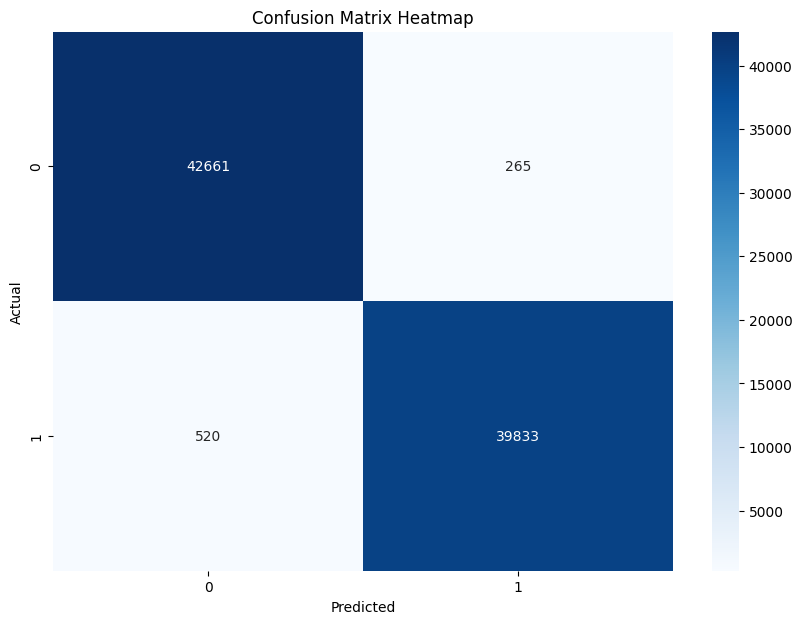

In [86]:
# Plot confusion matrix heatmap

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

### LightGBM Classification Report

In [87]:
print("LightGBM Classifier Accuracy:",metrics.accuracy_score(y_test, clf_lgb_predict))
print("LightGBM Classifier Recall:",metrics.recall_score(y_test, clf_lgb_predict))
print("LightGBM Classifier Precision:",metrics.precision_score(y_test, clf_lgb_predict))

report = classification_report(y_test, clf_lgb_predict)

print(report)

LightGBM Classifier Accuracy: 0.9905738541529077
LightGBM Classifier Recall: 0.9871137214085693
LightGBM Classifier Precision: 0.9933911915806275
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     42926
           1       0.99      0.99      0.99     40353

    accuracy                           0.99     83279
   macro avg       0.99      0.99      0.99     83279
weighted avg       0.99      0.99      0.99     83279



### LightGBM Train & Testing Accuracy

In [88]:
# Make predictions
y_train_lgb_pred = clf_lgb.predict(X_train)
y_test_lgb_pred = clf_lgb.predict(X_test)

# Calculate accuracy
train_accuracy = metrics.accuracy_score(y_train, y_train_lgb_pred)
test_accuracy = metrics.accuracy_score(y_test, y_test_lgb_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 1.0
Test Accuracy: 0.9905738541529077


## CatBoost Hyperparameter Classification Model

In [249]:
# Calculating best hyperparameter for CatBoost

def objective(trial):
    
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    depth = trial.suggest_int("depth", 3, 10)
    iterations = trial.suggest_int("iterations", 100, 1000)
         
    # Fixed 1000 iterations 
    cat_model = CatBoostClassifier(iterations=iterations, learning_rate=learning_rate,depth=depth, random_state=42)
    cat_model.fit(X_train, y_train)

    #To train model with parameters
    clf_Cat_pred = cat_model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, clf_Cat_pred)
    return accuracy

In [250]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print("Best trial:")
print(" Value: {}".format(study.best_trial.value))
print(" Params: {}".format(study.best_trial.params))

[I 2024-08-31 22:32:10,484] A new study created in memory with name: no-name-d0d9e501-5df6-4a17-a14e-85d9294873c7


0:	learn: 0.6485864	total: 277ms	remaining: 4m 37s
1:	learn: 0.6091172	total: 556ms	remaining: 4m 37s
2:	learn: 0.5729924	total: 814ms	remaining: 4m 30s
3:	learn: 0.5407055	total: 1.14s	remaining: 4m 43s
4:	learn: 0.5099600	total: 1.42s	remaining: 4m 42s
5:	learn: 0.4826213	total: 1.7s	remaining: 4m 41s
6:	learn: 0.4590412	total: 1.97s	remaining: 4m 39s
7:	learn: 0.4372430	total: 2.25s	remaining: 4m 39s
8:	learn: 0.4174518	total: 2.57s	remaining: 4m 42s
9:	learn: 0.3984716	total: 2.85s	remaining: 4m 42s
10:	learn: 0.3821621	total: 3.15s	remaining: 4m 43s
11:	learn: 0.3673810	total: 3.48s	remaining: 4m 46s
12:	learn: 0.3536242	total: 3.78s	remaining: 4m 46s
13:	learn: 0.3417345	total: 4.09s	remaining: 4m 47s
14:	learn: 0.3301894	total: 4.39s	remaining: 4m 48s
15:	learn: 0.3203368	total: 4.67s	remaining: 4m 47s
16:	learn: 0.3109506	total: 4.98s	remaining: 4m 47s
17:	learn: 0.3010775	total: 5.28s	remaining: 4m 48s
18:	learn: 0.2934371	total: 5.57s	remaining: 4m 47s
19:	learn: 0.2861002	to

[I 2024-08-31 22:37:35,517] Trial 0 finished with value: 0.9819901117197728 and parameters: {'learning_rate': 0.03526223027393899, 'depth': 6}. Best is trial 0 with value: 0.9819901117197728.


0:	learn: 0.6348654	total: 169ms	remaining: 2m 48s
1:	learn: 0.5840152	total: 361ms	remaining: 3m
2:	learn: 0.5412964	total: 537ms	remaining: 2m 58s
3:	learn: 0.5039339	total: 724ms	remaining: 3m
4:	learn: 0.4723655	total: 903ms	remaining: 2m 59s
5:	learn: 0.4451424	total: 1.12s	remaining: 3m 5s
6:	learn: 0.4214587	total: 1.31s	remaining: 3m 6s
7:	learn: 0.4005887	total: 1.5s	remaining: 3m 6s
8:	learn: 0.3830720	total: 1.7s	remaining: 3m 6s
9:	learn: 0.3670345	total: 1.89s	remaining: 3m 6s
10:	learn: 0.3542019	total: 2.08s	remaining: 3m 6s
11:	learn: 0.3423298	total: 2.27s	remaining: 3m 7s
12:	learn: 0.3326980	total: 2.45s	remaining: 3m 6s
13:	learn: 0.3221136	total: 2.65s	remaining: 3m 7s
14:	learn: 0.3134663	total: 2.87s	remaining: 3m 8s
15:	learn: 0.3070596	total: 3.07s	remaining: 3m 8s
16:	learn: 0.3000432	total: 3.26s	remaining: 3m 8s
17:	learn: 0.2945687	total: 3.44s	remaining: 3m 7s
18:	learn: 0.2883019	total: 3.63s	remaining: 3m 7s
19:	learn: 0.2818375	total: 3.85s	remaining: 3

[I 2024-08-31 22:41:22,229] Trial 1 finished with value: 0.9796642051881697 and parameters: {'learning_rate': 0.05796837750864053, 'depth': 4}. Best is trial 0 with value: 0.9819901117197728.


0:	learn: 0.6618869	total: 566ms	remaining: 9m 25s
1:	learn: 0.6328637	total: 1.12s	remaining: 9m 17s
2:	learn: 0.6060142	total: 1.66s	remaining: 9m 13s
3:	learn: 0.5806745	total: 2.23s	remaining: 9m 14s
4:	learn: 0.5564890	total: 2.8s	remaining: 9m 17s
5:	learn: 0.5339684	total: 3.34s	remaining: 9m 13s
6:	learn: 0.5136984	total: 3.95s	remaining: 9m 20s
7:	learn: 0.4936871	total: 4.51s	remaining: 9m 18s
8:	learn: 0.4757155	total: 5.07s	remaining: 9m 18s
9:	learn: 0.4581470	total: 5.62s	remaining: 9m 16s
10:	learn: 0.4421180	total: 6.18s	remaining: 9m 15s
11:	learn: 0.4275249	total: 6.74s	remaining: 9m 14s
12:	learn: 0.4131752	total: 7.29s	remaining: 9m 13s
13:	learn: 0.3998665	total: 7.82s	remaining: 9m 10s
14:	learn: 0.3867366	total: 8.36s	remaining: 9m 8s
15:	learn: 0.3735809	total: 8.89s	remaining: 9m 6s
16:	learn: 0.3621547	total: 9.45s	remaining: 9m 6s
17:	learn: 0.3501679	total: 9.99s	remaining: 9m 5s
18:	learn: 0.3411487	total: 10.5s	remaining: 9m 4s
19:	learn: 0.3321220	total: 

[I 2024-08-31 22:51:00,905] Trial 2 finished with value: 0.9828543829992755 and parameters: {'learning_rate': 0.02121818228659057, 'depth': 8}. Best is trial 2 with value: 0.9828543829992755.


0:	learn: 0.6818897	total: 124ms	remaining: 2m 4s
1:	learn: 0.6753880	total: 245ms	remaining: 2m 2s
2:	learn: 0.6647964	total: 372ms	remaining: 2m 3s
3:	learn: 0.6546618	total: 499ms	remaining: 2m 4s
4:	learn: 0.6449185	total: 629ms	remaining: 2m 5s
5:	learn: 0.6393284	total: 753ms	remaining: 2m 4s
6:	learn: 0.6301988	total: 886ms	remaining: 2m 5s
7:	learn: 0.6248650	total: 1.01s	remaining: 2m 5s
8:	learn: 0.6197340	total: 1.14s	remaining: 2m 5s
9:	learn: 0.6114222	total: 1.26s	remaining: 2m 5s
10:	learn: 0.6035776	total: 1.39s	remaining: 2m 4s
11:	learn: 0.5987507	total: 1.51s	remaining: 2m 4s
12:	learn: 0.5910744	total: 1.64s	remaining: 2m 4s
13:	learn: 0.5865525	total: 1.76s	remaining: 2m 4s
14:	learn: 0.5821371	total: 1.89s	remaining: 2m 4s
15:	learn: 0.5750674	total: 2.01s	remaining: 2m 3s
16:	learn: 0.5709325	total: 2.15s	remaining: 2m 4s
17:	learn: 0.5669543	total: 2.28s	remaining: 2m 4s
18:	learn: 0.5619445	total: 2.4s	remaining: 2m 3s
19:	learn: 0.5581580	total: 2.52s	remainin

[I 2024-08-31 22:53:53,382] Trial 3 finished with value: 0.9507238271965835 and parameters: {'learning_rate': 0.016669875952640002, 'depth': 2}. Best is trial 2 with value: 0.9828543829992755.


0:	learn: 0.6437890	total: 206ms	remaining: 3m 25s
1:	learn: 0.5991556	total: 447ms	remaining: 3m 43s
2:	learn: 0.5603259	total: 659ms	remaining: 3m 39s
3:	learn: 0.5252947	total: 894ms	remaining: 3m 42s
4:	learn: 0.4948479	total: 1.12s	remaining: 3m 43s
5:	learn: 0.4676011	total: 1.37s	remaining: 3m 46s
6:	learn: 0.4428753	total: 1.59s	remaining: 3m 45s
7:	learn: 0.4221198	total: 1.79s	remaining: 3m 42s
8:	learn: 0.4029253	total: 2.05s	remaining: 3m 46s
9:	learn: 0.3851298	total: 2.31s	remaining: 3m 48s
10:	learn: 0.3692245	total: 2.56s	remaining: 3m 49s
11:	learn: 0.3547802	total: 2.81s	remaining: 3m 51s
12:	learn: 0.3423849	total: 3.05s	remaining: 3m 51s
13:	learn: 0.3311845	total: 3.3s	remaining: 3m 52s
14:	learn: 0.3210533	total: 3.54s	remaining: 3m 52s
15:	learn: 0.3113860	total: 3.78s	remaining: 3m 52s
16:	learn: 0.3033939	total: 4.01s	remaining: 3m 51s
17:	learn: 0.2970904	total: 4.25s	remaining: 3m 51s
18:	learn: 0.2906729	total: 4.49s	remaining: 3m 51s
19:	learn: 0.2856603	to

[I 2024-08-31 22:58:21,991] Trial 4 finished with value: 0.9808080936463351 and parameters: {'learning_rate': 0.043560566333566586, 'depth': 5}. Best is trial 2 with value: 0.9828543829992755.


0:	learn: 0.6488167	total: 280ms	remaining: 4m 39s
1:	learn: 0.6095305	total: 561ms	remaining: 4m 40s
2:	learn: 0.5735548	total: 814ms	remaining: 4m 30s
3:	learn: 0.5413836	total: 1.12s	remaining: 4m 39s
4:	learn: 0.5107351	total: 1.41s	remaining: 4m 40s
5:	learn: 0.4834589	total: 1.69s	remaining: 4m 39s
6:	learn: 0.4599266	total: 1.95s	remaining: 4m 37s
7:	learn: 0.4381548	total: 2.23s	remaining: 4m 36s
8:	learn: 0.4183862	total: 2.54s	remaining: 4m 40s
9:	learn: 0.3995958	total: 2.83s	remaining: 4m 40s
10:	learn: 0.3829833	total: 3.14s	remaining: 4m 42s
11:	learn: 0.3685567	total: 3.44s	remaining: 4m 43s
12:	learn: 0.3550313	total: 3.75s	remaining: 4m 44s
13:	learn: 0.3421829	total: 4.03s	remaining: 4m 43s
14:	learn: 0.3306390	total: 4.32s	remaining: 4m 43s
15:	learn: 0.3196252	total: 4.62s	remaining: 4m 44s
16:	learn: 0.3102173	total: 4.92s	remaining: 4m 44s
17:	learn: 0.3019530	total: 5.23s	remaining: 4m 45s
18:	learn: 0.2938734	total: 5.51s	remaining: 4m 44s
19:	learn: 0.2865279	t

[I 2024-08-31 23:03:45,362] Trial 5 finished with value: 0.9822315992831633 and parameters: {'learning_rate': 0.03507306588864308, 'depth': 6}. Best is trial 2 with value: 0.9828543829992755.


0:	learn: 0.6861116	total: 2.51s	remaining: 41m 43s
1:	learn: 0.6796439	total: 5.3s	remaining: 44m 3s
2:	learn: 0.6732423	total: 8.03s	remaining: 44m 28s
3:	learn: 0.6663625	total: 11.2s	remaining: 46m 18s
4:	learn: 0.6596506	total: 13.9s	remaining: 46m 15s
5:	learn: 0.6535793	total: 16.9s	remaining: 46m 45s
6:	learn: 0.6477035	total: 19.6s	remaining: 46m 26s
7:	learn: 0.6417727	total: 22.4s	remaining: 46m 20s
8:	learn: 0.6358988	total: 25.4s	remaining: 46m 40s
9:	learn: 0.6297710	total: 28.3s	remaining: 46m 37s
10:	learn: 0.6235762	total: 31.1s	remaining: 46m 38s
11:	learn: 0.6173636	total: 34s	remaining: 46m 38s
12:	learn: 0.6109605	total: 36.9s	remaining: 46m 41s
13:	learn: 0.6052164	total: 39.8s	remaining: 46m 46s
14:	learn: 0.5993761	total: 42.8s	remaining: 46m 51s
15:	learn: 0.5939663	total: 45.9s	remaining: 47m 4s
16:	learn: 0.5886753	total: 48.8s	remaining: 46m 58s
17:	learn: 0.5830218	total: 51.5s	remaining: 46m 47s
18:	learn: 0.5779776	total: 54.4s	remaining: 46m 48s
19:	lear

[I 2024-08-31 23:57:47,556] Trial 6 finished with value: 0.9706020666251477 and parameters: {'learning_rate': 0.004058218524679966, 'depth': 10}. Best is trial 2 with value: 0.9828543829992755.


0:	learn: 0.6890263	total: 211ms	remaining: 3m 31s
1:	learn: 0.6849388	total: 430ms	remaining: 3m 34s
2:	learn: 0.6808027	total: 655ms	remaining: 3m 37s
3:	learn: 0.6767919	total: 873ms	remaining: 3m 37s
4:	learn: 0.6728051	total: 1.1s	remaining: 3m 38s
5:	learn: 0.6688185	total: 1.32s	remaining: 3m 38s
6:	learn: 0.6649039	total: 1.53s	remaining: 3m 37s
7:	learn: 0.6609898	total: 1.75s	remaining: 3m 37s
8:	learn: 0.6571553	total: 1.97s	remaining: 3m 37s
9:	learn: 0.6533364	total: 2.19s	remaining: 3m 36s
10:	learn: 0.6495791	total: 2.42s	remaining: 3m 37s
11:	learn: 0.6458560	total: 2.63s	remaining: 3m 36s
12:	learn: 0.6421913	total: 2.85s	remaining: 3m 36s
13:	learn: 0.6385592	total: 3.07s	remaining: 3m 36s
14:	learn: 0.6349961	total: 3.3s	remaining: 3m 36s
15:	learn: 0.6314536	total: 3.52s	remaining: 3m 36s
16:	learn: 0.6278890	total: 3.74s	remaining: 3m 36s
17:	learn: 0.6243916	total: 3.98s	remaining: 3m 37s
18:	learn: 0.6209086	total: 4.2s	remaining: 3m 36s
19:	learn: 0.6174020	tota

[I 2024-09-01 00:02:44,805] Trial 7 finished with value: 0.9467583472082767 and parameters: {'learning_rate': 0.0035087436829602477, 'depth': 5}. Best is trial 2 with value: 0.9828543829992755.


0:	learn: 0.6748582	total: 945ms	remaining: 15m 44s
1:	learn: 0.6569999	total: 1.83s	remaining: 15m 12s
2:	learn: 0.6394341	total: 2.75s	remaining: 15m 13s
3:	learn: 0.6232607	total: 3.64s	remaining: 15m 6s
4:	learn: 0.6070047	total: 4.53s	remaining: 15m 1s
5:	learn: 0.5912010	total: 5.43s	remaining: 14m 59s
6:	learn: 0.5760413	total: 6.32s	remaining: 14m 56s
7:	learn: 0.5614999	total: 7.15s	remaining: 14m 46s
8:	learn: 0.5475639	total: 7.99s	remaining: 14m 39s
9:	learn: 0.5343678	total: 8.9s	remaining: 14m 41s
10:	learn: 0.5221435	total: 9.74s	remaining: 14m 36s
11:	learn: 0.5099659	total: 10.6s	remaining: 14m 33s
12:	learn: 0.4969503	total: 11.5s	remaining: 14m 33s
13:	learn: 0.4857054	total: 12.4s	remaining: 14m 31s
14:	learn: 0.4744197	total: 13.2s	remaining: 14m 29s
15:	learn: 0.4629874	total: 14.1s	remaining: 14m 29s
16:	learn: 0.4521057	total: 15s	remaining: 14m 26s
17:	learn: 0.4411062	total: 15.8s	remaining: 14m 24s
18:	learn: 0.4310831	total: 16.7s	remaining: 14m 21s
19:	lear

[I 2024-09-01 00:18:18,610] Trial 8 finished with value: 0.9802615691607671 and parameters: {'learning_rate': 0.012075432840971123, 'depth': 9}. Best is trial 2 with value: 0.9828543829992755.


0:	learn: 0.6810558	total: 182ms	remaining: 3m 1s
1:	learn: 0.6694514	total: 381ms	remaining: 3m 10s
2:	learn: 0.6581088	total: 583ms	remaining: 3m 13s
3:	learn: 0.6470635	total: 772ms	remaining: 3m 12s
4:	learn: 0.6361281	total: 974ms	remaining: 3m 13s
5:	learn: 0.6257542	total: 1.17s	remaining: 3m 13s
6:	learn: 0.6156891	total: 1.35s	remaining: 3m 11s
7:	learn: 0.6061307	total: 1.54s	remaining: 3m 11s
8:	learn: 0.5964229	total: 1.74s	remaining: 3m 12s
9:	learn: 0.5869944	total: 1.94s	remaining: 3m 12s
10:	learn: 0.5778794	total: 2.14s	remaining: 3m 12s
11:	learn: 0.5692879	total: 2.33s	remaining: 3m 11s
12:	learn: 0.5608007	total: 2.53s	remaining: 3m 11s
13:	learn: 0.5524708	total: 2.73s	remaining: 3m 12s
14:	learn: 0.5445413	total: 2.92s	remaining: 3m 11s
15:	learn: 0.5367059	total: 3.12s	remaining: 3m 11s
16:	learn: 0.5291083	total: 3.32s	remaining: 3m 12s
17:	learn: 0.5217470	total: 3.53s	remaining: 3m 12s
18:	learn: 0.5145872	total: 3.72s	remaining: 3m 12s
19:	learn: 0.5076736	to

[I 2024-09-01 00:22:21,606] Trial 9 finished with value: 0.959900354605422 and parameters: {'learning_rate': 0.011567912838591118, 'depth': 4}. Best is trial 2 with value: 0.9828543829992755.


Best trial:
 Value: 0.9828543829992755
 Params: {'learning_rate': 0.02121818228659057, 'depth': 8}


In [89]:
clf_cat = CatBoostClassifier(iterations=1000,learning_rate=0.02121818228659057, depth=8)
clf_cat.fit(X_train, y_train,verbose=True)

0:	learn: 0.6616715	total: 545ms	remaining: 9m 4s
1:	learn: 0.6342692	total: 1.07s	remaining: 8m 53s
2:	learn: 0.6077696	total: 1.62s	remaining: 8m 58s
3:	learn: 0.5835322	total: 2.14s	remaining: 8m 52s
4:	learn: 0.5597314	total: 2.68s	remaining: 8m 53s
5:	learn: 0.5374524	total: 3.23s	remaining: 8m 55s
6:	learn: 0.5164040	total: 3.76s	remaining: 8m 52s
7:	learn: 0.4963434	total: 4.31s	remaining: 8m 54s
8:	learn: 0.4763533	total: 4.82s	remaining: 8m 50s
9:	learn: 0.4590408	total: 5.35s	remaining: 8m 49s
10:	learn: 0.4423793	total: 5.87s	remaining: 8m 47s
11:	learn: 0.4261496	total: 6.44s	remaining: 8m 50s
12:	learn: 0.4122203	total: 7s	remaining: 8m 51s
13:	learn: 0.3990517	total: 7.54s	remaining: 8m 51s
14:	learn: 0.3853219	total: 8.06s	remaining: 8m 49s
15:	learn: 0.3720151	total: 8.63s	remaining: 8m 50s
16:	learn: 0.3616835	total: 9.2s	remaining: 8m 51s
17:	learn: 0.3515897	total: 9.73s	remaining: 8m 50s
18:	learn: 0.3421088	total: 10.3s	remaining: 8m 50s
19:	learn: 0.3315545	total:

In [90]:
clf_cat_pred = clf_cat.predict(X_test)
print("CatBoost Classifier Accuracy:",accuracy_score(y_test, clf_cat_pred))
print("CatBoost Classifier Recall:",recall_score(y_test, clf_cat_pred))
print("CatBoost Classifier Precision:",precision_score(y_test, clf_cat_pred))

CatBoost Classifier Accuracy: 0.9813398335714886
CatBoost Classifier Recall: 0.9765816667905732
CatBoost Classifier Precision: 0.9847814678761526


In [91]:
report = classification_report(y_test, clf_cat_pred)
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     42926
           1       0.98      0.98      0.98     40353

    accuracy                           0.98     83279
   macro avg       0.98      0.98      0.98     83279
weighted avg       0.98      0.98      0.98     83279



In [92]:
# Make predictions
y_train_cat_pred = clf_cat.predict(X_train)
y_test_cat_pred = clf_cat.predict(X_test)

# Calculate accuracy
train_accuracy = metrics.accuracy_score(y_train, y_train_cat_pred)
test_accuracy = metrics.accuracy_score(y_test, y_test_cat_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 0.9857586719301142
Test Accuracy: 0.9813398335714886


# Performance Comparision of Base Learners after hyperparameter tuning

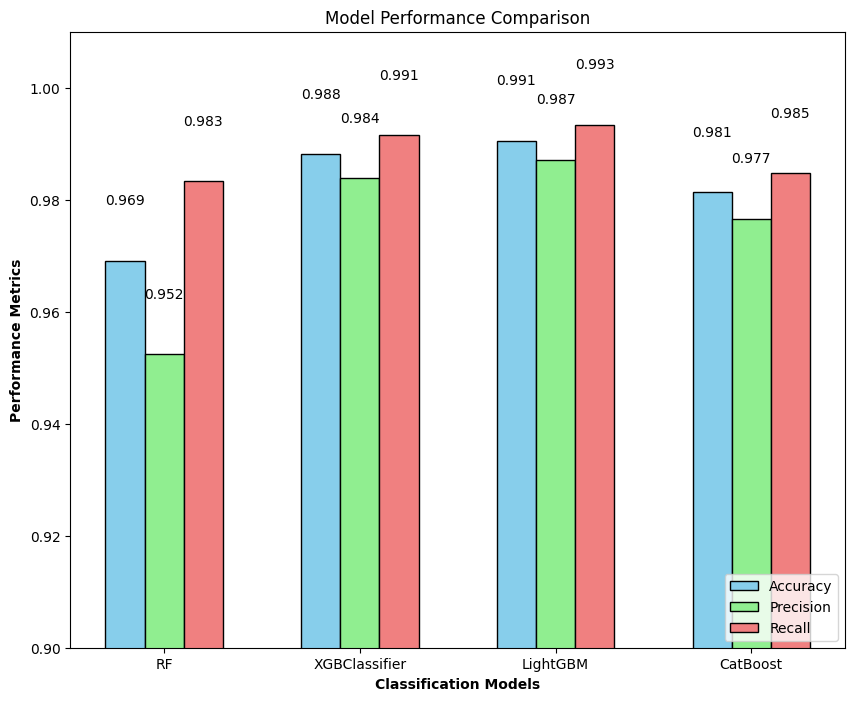

In [128]:
import matplotlib.pyplot as plt
import numpy as np

# Example values for each metric (replace these with your actual values)
metrics = {
    'RF' :  {'accuracy': accuracy_score(y_test, y_pred_rf), 'precision': recall_score(y_test, y_pred_rf), 'recall': precision_score(y_test, y_pred_rf)},
    'XGBClassifier': {'accuracy': accuracy_score(y_test, XGB_pred), 'precision': recall_score(y_test, XGB_pred), 'recall': precision_score(y_test, XGB_pred)},
    'LightGBM': {'accuracy': accuracy_score(y_test, clf_lgb_predict), 'precision': recall_score(y_test, clf_lgb_predict), 'recall': precision_score(y_test, clf_lgb_predict)},
    'CatBoost': {'accuracy': accuracy_score(y_test, clf_cat_pred), 'precision': recall_score(y_test, clf_cat_pred), 'recall': precision_score(y_test, clf_cat_pred)}
}

# Models and metric categories
models = list(metrics.keys())
categories = ['accuracy', 'precision', 'recall']

# Extracting the values
accuracy_values = [metrics[model]['accuracy'] for model in models]
precision_values = [metrics[model]['precision'] for model in models]
recall_values = [metrics[model]['recall'] for model in models]

# Define bar width and positions
bar_width = 0.2
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar chart
plt.figure(figsize=(10, 8))
plt.bar(r1, accuracy_values, color='skyblue', width=bar_width, edgecolor='black', label='Accuracy')
plt.bar(r2, precision_values, color='lightgreen', width=bar_width, edgecolor='black', label='Precision')
plt.bar(r3, recall_values, color='lightcoral', width=bar_width, edgecolor='black', label='Recall')

# Add labels and title
plt.xlabel('Classification Models', fontweight='bold')
plt.ylabel('Performance Metrics', fontweight='bold')
plt.title('Model Performance Comparison')
plt.xticks([r + bar_width for r in range(len(models))], models)
plt.ylim(0.90, 1.01)  # Set y-axis from 0 to 1

# Add legend
plt.legend(loc='lower right')

# Add values on top of bars
for i in range(len(r1)):
    plt.text(r1[i], accuracy_values[i] + 0.01, f'{accuracy_values[i]:.3f}', ha='center')
    plt.text(r2[i], precision_values[i] + 0.01, f'{precision_values[i]:.3f}', ha='center')
    plt.text(r3[i], recall_values[i] + 0.01, f'{recall_values[i]:.3f}', ha='center')

# Show plot
plt.show()

# Stacking Classification Model

## Zero Level Stacking

In [93]:
base_lvl_learners = []
base_lvl_learners.append(('XGB', XGBClassifier(objective="binary:logistic",random_state=13,n_estimators=1000,
    learning_rate=0.1,
    max_depth=8,
    colsample_bytree=0.5)))
base_lvl_learners.append(('LightGBM', LGBMClassifier(learning_rate= 0.05092019196120222,
num_leaves = 200,
max_depth = 22,
min_child_samples = 50,
subsample = 0.9808438292511631,
colsample_bytree = 0.8200479625575507,
n_estimators = 1000)))
base_lvl_learners.append(('RF', RandomForestClassifier()))

## First Level Stacking

In [94]:
meta_lvl_clf = CatBoostClassifier(iterations=2000,learning_rate=0.1, depth=8 )

## Stacking Classifier

In [95]:
SC = StackingClassifier(estimators=base_lvl_learners,final_estimator=meta_lvl_clf )

In [96]:
SC.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 161413, number of negative: 171702
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.721121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197263
[LightGBM] [Info] Number of data points in the train set: 333115, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484556 -> initscore=-0.061794
[LightGBM] [Info] Start training from score -0.061794
[LightGBM] [Info] Number of positive: 129131, number of negative: 137361
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.429259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 197259
[LightGBM] [Info] Number of data points in the train set: 266492, number of used features: 786
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484559 -> initscore=-0.061785
[LightGBM] [Info] Start training from score -0.061785


StackingClassifier(estimators=[('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.5, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_r...
                                              random_state=13, ...)),
                               ('LightGBM',
                                LGBMClassifier(colsample_bytree=0.8200479625575507,
                                               learning_rate=0.05092019196120222,
                                               max_depth=22,
                                               min_child_samples=50,
                                               n_estimators=1000,
                                               num_leaves=200,
                                               subsample=0.9808438292511631)),
                               ('RF',
                                RandomForestClassifier(max_depth=9,
                                                       max_leaf_nodes=9))],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x0000022231509550>)

## Stacking Classifier Performance Metrics

In [97]:
SC_pred = SC.predict(X_test)

In [132]:
SC_pred_prob = SC.predict_proba(X_test)

In [139]:
SC_pred_prob[0]

array([1.19553110e-05, 9.99988045e-01])

In [135]:
if SC_pred_prob.shape[1] == 2:  # Check if it's binary classification
    residuals = SC_pred_prob[:, 1] - (y_test == 1).astype(int)
else:
    residuals = np.mean(SC_pred_prob, axis=1) - np.mean(y_test) 

in if


In [137]:
from scipy import stats
import numpy as np
stat, p_value = stats.shapiro(residuals)

print(f'Statistic: {stat}, p-value: {p_value}')
if p_value > 0.05:
    print("Residuals appear to be normally distributed (fail to reject H0).")
else:
    print("Residuals do not appear to be normally distributed (reject H0).")

Statistic: 0.18823037825877975, p-value: 6.021137348915463e-172
Residuals do not appear to be normally distributed (reject H0).


In [98]:
print("Stacking Classifier Performance Report")
print("---------------------------------------")
print("Stacking Classifier Accuracy\t:",accuracy_score(y_test, SC_pred))
print("Stacking Classifier Recall\t:",recall_score(y_test, SC_pred))
print("Stacking  Classifier Precision\t:",precision_score(y_test, SC_pred))
print("Stacking  Classifier F1 Score\t:",f1_score(y_test, SC_pred))

print("\nClassification Report")
print("------------------------")
print(report)

Stacking Classifier Performance Report
---------------------------------------
Stacking Classifier Accuracy	: 0.9914504256775417
Stacking Classifier Recall	: 0.9894183827720368
Stacking  Classifier Precision	: 0.9929123871577429
Stacking  Classifier F1 Score	: 0.9911623057445013

Classification Report
------------------------
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     42926
           1       0.98      0.98      0.98     40353

    accuracy                           0.98     83279
   macro avg       0.98      0.98      0.98     83279
weighted avg       0.98      0.98      0.98     83279



In [99]:
# Make predictions
y_train_lgb_pred = SC.predict(X_train)
y_test_lgb_pred = SC.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_lgb_pred)
test_accuracy = accuracy_score(y_test, y_test_lgb_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Training Accuracy: 1.0
Test Accuracy: 0.9914504256775417


In [100]:
fpr,tpr, thres=roc_curve(y_test, SC_pred)

C:\Users\kanis\AppData\Local\Temp\ipykernel_8832\2564773766.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier',lw=1,color='brown')


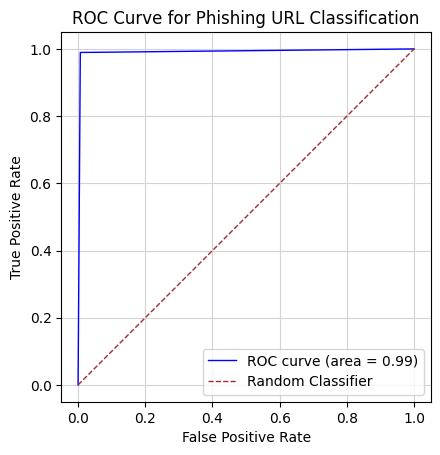

In [101]:
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc,lw=1, color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier',lw=1,color='brown')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Phishing URL Classification')
plt.legend()
plt.grid(True, color='lightgrey')
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig('ROC.png', dpi=300)
plt.show()

In [102]:
from sklearn.metrics import confusion_matrix

# Getting the confusion matrix
cm = confusion_matrix(y_test, SC_pred)
tn, fp, fn, tp = cm.ravel()

# Calculating False Positive Rate (FPR)
fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

False Positive Rate: 0.0066


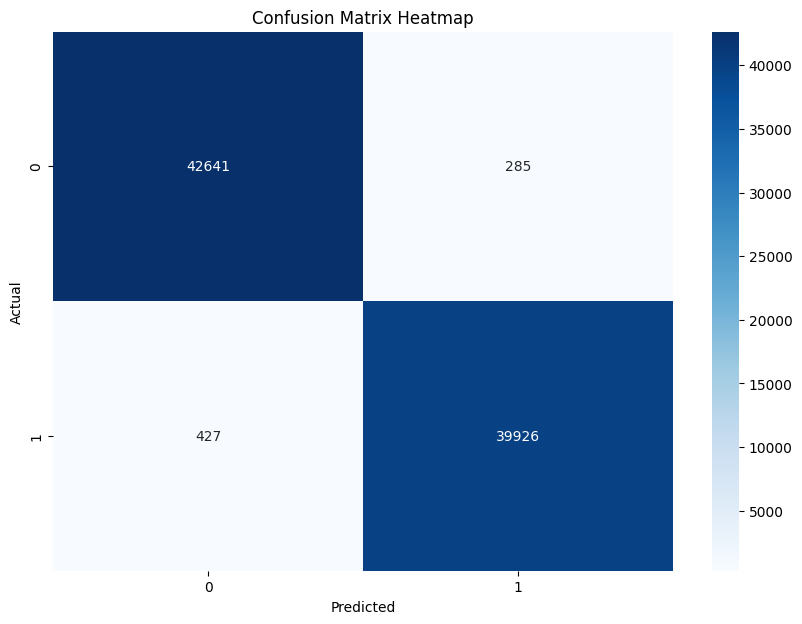

In [103]:
# Plotting confusion matrix heatmap

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

## Saving Stacking Classifier Model

In [272]:
from joblib import Parallel, delayed 
import joblib 

In [278]:
# To save the model
joblib.dump(SC, 'D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\S_BERT_Dataset\\V6\\SC-Disser-mainFinal.pkl')  

['D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\S_BERT_Dataset\\V6\\SC-Disser-mainFinal.pkl']

# Loading Classifier Model

In [57]:
Stacking_Classifier_url=joblib.load('D:\\Learnings\\Masters_TUD\\Dissertation\\Datasets\\S_BERT_Dataset\\V6\\SC-KNN-mainFinal.pkl')

In [156]:
Stacking_Classifier_url.score(X_test,y_test)

0.9955007237966066

In [157]:
# Step 2: Make predictions on the test set
y_pred = Stacking_Classifier_url.predict(X_test)

# Step 3: Generate the classification report
report = classification_report(y_test, y_pred)

In [158]:
report = classification_report(y_test, y_pred)
print("\nPerformance Metrics : ")
print("----------------------\n")

print("Stacking Classifier Accuracy   :",accuracy_score(y_test, y_pred))
print("Stacking Classifier Recall     :",recall_score(y_test, y_pred))
print("Stacking Classifier Precision  :",precision_score(y_test, y_pred))

print("\nClasification Report :")
print("-----------------------\n")

print(report)


Performance Metrics : 
----------------------

Stacking Classifier Accuracy   : 0.9955007237966066
Stacking Classifier Recall     : 0.997258068573441
Stacking Classifier Precision  : 0.9940822467402206

Clasification Report :
-----------------------

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     36926
           1       0.99      1.00      1.00     39753

    accuracy                           1.00     76679
   macro avg       1.00      1.00      1.00     76679
weighted avg       1.00      1.00      1.00     76679



In [159]:
fpr,tpr, thres=roc_curve(y_test, y_pred)

In [60]:
fpr

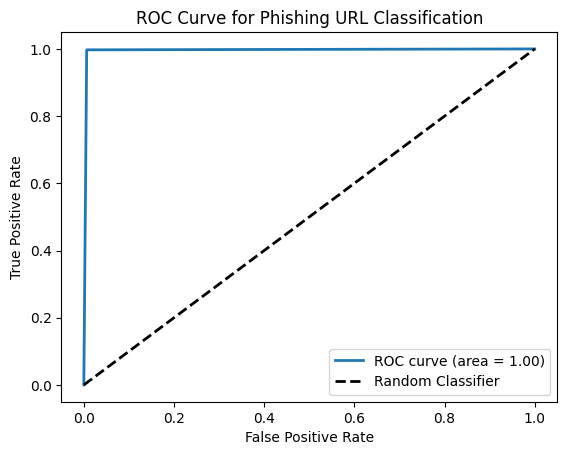

In [160]:
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc,lw=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier',lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Phishing URL Classification')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [162]:
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate False Positive Rate (FPR)
fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

False Positive Rate: 0.0064


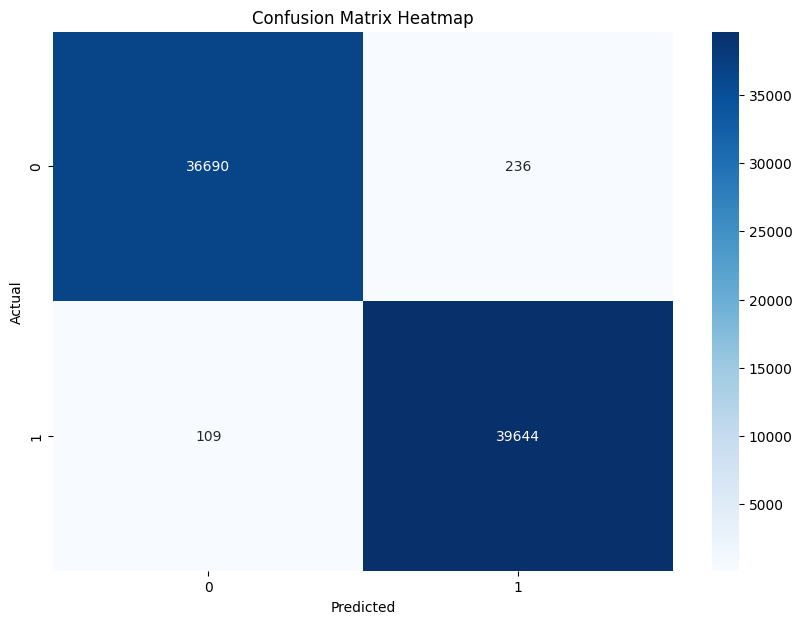

In [163]:
# Plot confusion matrix heatmap

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()

# Short URL Handler

In [360]:
input_url='https://www.youtube.com/watch?v=M72Wu2rZE7Y&t=2043s'

In [361]:
test_url_features=extract_URL_features(input_url)
test_url_encoder=[s_bert_model.encode(input_url)]
test_url_features = pd.json_normalize(test_url_features)

In [362]:
test_features

,url_length,domain_length,path_length,num_subdomains,subdomain_length,path_depth,has_file_extension,equal_count,redirects,query_param_count,dot_char_count,hyphen_char_count,tld_domain_length,space_char_count,www_count,http_count,suspicious_path_keywords
0,51,15,6,1,3,1,0,2,1,1,2,0,3,0,1,1,0


In [363]:
test_url_df=pd.concat([test_url_features])

In [364]:
test_url_df['embeddings']=test_url_encoder

In [365]:
test_url_df.embeddings

0    [-0.054456674, 0.06418925, 0.087920085, 0.0451...
Name: embeddings, dtype: object

In [366]:
# Selecting numeric features excluding 'type'
features = test_url.drop(columns=['embeddings'])

# Normalizing numeric features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Converting embeddings to a 2D array
embeddings_array = np.stack(test_url_df['embeddings'].values)

# Concatenating features and embeddings
ANALYZE_URL = np.hstack((features_scaled, embeddings_array))

In [368]:
model_res=lr.predict(ANALYZE_URL)

In [61]:
if(model_res[0]==0):
    print("The URL is legitimate")
else:
    print("The URL is malicious")

The URL is legitimate


In [ ]:
!pip install pycurl import pycurl

In [ ]:
test='https://www.youtube.com/watch?v=M72Wu2rZE7Y&t=2043s'

In [ ]:
try:
    conn = pycurl.Curl()
    conn.setopt(pycurl.URL, test)
    conn.setopt(pycurl.FOLLOWLOCATION, 1)
    conn.setopt(pycurl.CUSTOMREQUEST, 'HEAD')
    conn.setopt(pycurl.NOBODY, True)
    conn.perform()
    expanded_url=conn.getinfo(pycurl.EFFECTIVE_URL)
    print(expanded_url)
except Exception as e:
    print("Unable to extract the Full URL. Could be a malicious site ")

In [ ]:
test_features=extract_URL_features(test)
test_encoder=[s_bert_model.encode(test)]
test_features = pd.json_normalize(test_features)

In [ ]:
test_features

In [ ]:
test_url=pd.concat([test_features])

In [ ]:
test_url['embeddings']=test_encoder

In [ ]:
test_url.embeddings

In [ ]:

features = test_url.drop(columns=['embeddings'])
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Convert embeddings to a 2D array
embeddings_array = np.stack(test_url['embeddings'].values)

# Concatenate features and embeddings
TEST = np.hstack((features_scaled, embeddings_array))

In [ ]:
res=lr.predict(TEST)

In [ ]:
if(res==0):
    print("The URL is legitimate")
else:
    print("The URL is malicious")